# Dyson Orbital Handler (Refactored)

This notebook implements a Dyson Orbital reader and visualizer, strictly following the logic from the provided reference implementation (`basis.py`, `parser.py`, `dyson.py`). It handles Gaussian basis sets, pure/cartesian shells, and Q-Chem output parsing robustly.

## 1. Setup and Imports

In [137]:
from __future__ import annotations
import re
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, Iterable, List, Sequence, Tuple, Optional
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D

try:
    from skimage.measure import marching_cubes
    HAS_SKIMAGE = True
except ImportError:
    HAS_SKIMAGE = False
    print("Warning: scikit-image not found. Isosurface visualization will be limited.")

## 2. Basis Set Handling (`basis.py`)

Core data structures and normalization logic.

In [138]:
ANGULAR_LETTER_TO_L = {"S": 0, "P": 1, "D": 2, "F": 3, "G": 4}
BOHR_TO_ANGSTROM = 0.529177210903
ANGSTROM_TO_BOHR = 1.0 / BOHR_TO_ANGSTROM
EPS = 1.0e-14

@dataclass
class ShellSpec:
    """Minimal description of a contracted Gaussian shell."""
    angular_momentum: int
    exponents: np.ndarray  # shape = (n_primitives,)
    coefficients: np.ndarray  # shape = (n_contractions, n_primitives)
    is_pure: bool
    symbol: str
    label: str
    center_bohr: np.ndarray

    def __post_init__(self) -> None:
        if self.coefficients.ndim != 2:
            raise ValueError("Shell coefficients must be a 2D array")
        if self.exponents.ndim != 1:
            raise ValueError("Shell exponents must be a 1D array")
        if self.coefficients.shape[1] != self.exponents.size:
            raise ValueError("Number of primitives mismatches between coefficients and exponents")
        self.center_bohr = np.asarray(self.center_bohr, dtype=float)

    @property
    def n_contractions(self) -> int:
        return self.coefficients.shape[0]

    @property
    def n_primitives(self) -> int:
        return self.exponents.size

@dataclass
class AtomSpec:
    """Atom entry paired with all contracted shells centred at center_bohr."""
    symbol: str
    index: int
    center_bohr: np.ndarray
    shells: List[ShellSpec] = field(default_factory=list)

def double_factorial(n: int) -> int:
    if n <= 0:
        return 1
    result = 1
    while n > 1:
        result *= n
        n -= 2
    return result

def norm_cartesian_gaussian(alpha: float, lx: int, ly: int, lz: int) -> float:
    l = lx + ly + lz
    prefactor = (2.0 * alpha / np.pi) ** 0.75
    numerator = (4.0 * alpha) ** l
    denom = (
        double_factorial(2 * lx - 1)
        * double_factorial(2 * ly - 1)
        * double_factorial(2 * lz - 1)
    )
    return prefactor * np.sqrt(numerator / denom)

def gaussian_primitive(
    alpha: float, lx: int, ly: int, lz: int,
    X: np.ndarray, Y: np.ndarray, Z: np.ndarray,
    center: Sequence[float],
) -> np.ndarray:
    cx, cy, cz = center
    xs = X - cx
    ys = Y - cy
    zs = Z - cz
    r2 = xs * xs + ys * ys + zs * zs
    
    prefactor = norm_cartesian_gaussian(alpha, lx, ly, lz)
    
    # Compute powers safely
    if lx: v_x = xs ** lx
    else:  v_x = np.ones_like(X)
        
    if ly: v_y = ys ** ly
    else:  v_y = np.ones_like(Y)
        
    if lz: v_z = zs ** lz
    else:  v_z = np.ones_like(Z)
        
    return prefactor * v_x * v_y * v_z * np.exp(-alpha * r2)

def cartesian_monomials(l: int) -> List[Tuple[int, int, int]]:
    combos = []
    for lx in range(l, -1, -1):
        for ly in range(l - lx, -1, -1):
            lz = l - lx - ly
            combos.append((lx, ly, lz))
    return combos

PURE_COMBO_COEFFS = {
    2: [
        [(1.0, (1, 1, 0))], # dxy
        [(1.0, (0, 1, 1))], # dyz
        [(1.0, (0, 0, 2)), (-0.5, (2, 0, 0)), (-0.5, (0, 2, 0))], # dz2
        [(1.0, (1, 0, 1))], # dxz
        [(np.sqrt(3.0) / 2.0, (2, 0, 0)), (-np.sqrt(3.0) / 2.0, (0, 2, 0))], # dx2-y2
    ],
    3: [
        [(np.sqrt(5.0/8.0)*3.0, (2,1,0)), (-np.sqrt(5.0/8.0), (0,3,0))],
        [(1.0, (1,1,1))],
        [(np.sqrt(3.0/8.0)*4.0, (0,1,2)), (-np.sqrt(3.0/8.0), (0,3,0)), (-np.sqrt(3.0/8.0), (2,1,0))],
        [(1.0, (0,0,3)), (-1.5, (2,0,1)), (-1.5, (0,2,1))],
        [(np.sqrt(3.0/8.0)*4.0, (1,0,2)), (-np.sqrt(3.0/8.0), (3,0,0)), (-np.sqrt(3.0/8.0), (1,2,0))],
        [(np.sqrt(15.0)/2.0, (2,0,1)), (-np.sqrt(15.0)/2.0, (0,2,1))],
        [(np.sqrt(5.0/8.0), (3,0,0)), (-3.0*np.sqrt(5.0/8.0), (1,2,0))],
    ],
    4: [
        [(np.sqrt(35.0)/2.0, (3, 1, 0)), (-np.sqrt(35.0)/2.0, (1, 3, 0))],
        [(3.0*np.sqrt(35.0/8.0), (2, 1, 1)), (-np.sqrt(35.0/8.0), (0, 3, 1))],
        [(3.0*np.sqrt(5.0), (1, 1, 2)), (-np.sqrt(5.0)/2.0, (3, 1, 0)), (-np.sqrt(5.0)/2.0, (1, 3, 0))],
        [(4.0*np.sqrt(5.0/8.0), (1, 0, 3)), (-3.0*np.sqrt(5.0/8.0), (3, 0, 1)), (-3.0*np.sqrt(5.0/8.0), (1, 2, 1))],
        [(1.0, (0, 0, 4)), (3.0/8.0, (4, 0, 0)), (3.0/8.0, (0, 4, 0)), (-3.0, (2, 0, 2)), (-3.0, (0, 2, 2)), (0.75, (2, 2, 0))],
        [(4.0*np.sqrt(5.0/8.0), (0, 1, 3)), (-3.0*np.sqrt(5.0/8.0), (2, 1, 1)), (-3.0*np.sqrt(5.0/8.0), (0, 3, 1))],
        [(1.5*np.sqrt(5.0), (2, 0, 2)), (-0.25*np.sqrt(5.0), (4, 0, 0)), (-1.5*np.sqrt(5.0), (0, 2, 2)), (0.25*np.sqrt(5.0), (0, 4, 0))],
        [(np.sqrt(35.0/8.0), (3, 0, 1)), (-3.0*np.sqrt(35.0/8.0), (1, 2, 1))],
        [(np.sqrt(35.0)/8.0, (4, 0, 0)), (np.sqrt(35.0)/8.0, (0, 4, 0)), (-3.0*np.sqrt(35.0)/4.0, (2, 2, 0))],
    ],
}

def build_primitive_bundle(exponents, lx, ly, lz, center, X, Y, Z, dV):
    values = [
        gaussian_primitive(alpha, lx, ly, lz, X, Y, Z, center)
        for alpha in exponents
    ]
    n = len(values)
    overlap = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i, n):
            val = float(np.sum(values[i] * values[j]) * dV)
            overlap[i, j] = val
            overlap[j, i] = val
    return values, overlap

def contract_gaussians(primitives, overlap, coeffs):
    coeffs = np.asarray(coeffs, dtype=float)
    ao = np.zeros_like(primitives[0])
    for c, prim in zip(coeffs, primitives):
        ao = ao + c * prim
        
    norm_sq = float(coeffs @ overlap @ coeffs)
    if norm_sq < 1.0e-14:
        return ao * 0.0
    norm_const = 1.0 / np.sqrt(norm_sq)
    return norm_const * ao

def degeneracy(l: int, is_pure: bool) -> int:
    if l == 0: return 1
    if l == 1: return 3
    if is_pure: return 2 * l + 1
    return (l + 1) * (l + 2) // 2

def enumerate_shell_functions(shell, center, X, Y, Z, dV):
    l = shell.angular_momentum
    if shell.is_pure and l >= 2:
        if l not in PURE_COMBO_COEFFS:
             raise NotImplementedError(f"Pure functions l={l} not impl")
        combos = PURE_COMBO_COEFFS[l]
        monomials = {mon for combo in combos for _, mon in combo}
    else:
        combos = [[(1.0, mon)] for mon in cartesian_monomials(l)]
        monomials = [combo[0][1] for combo in combos]

    primitive_cache = {}
    for mon in monomials:
        primitive_cache[mon] = build_primitive_bundle(
            shell.exponents, mon[0], mon[1], mon[2], center, X, Y, Z, dV
        )

    functions = []
    for contraction_idx in range(shell.n_contractions):
        coeff_vector = shell.coefficients[contraction_idx]
        cart_functions = {}
        for mon in monomials:
            primitives, overlap = primitive_cache[mon]
            cart_functions[mon] = contract_gaussians(primitives, overlap, coeff_vector)
        
        for combo in combos:
            orb = np.zeros_like(X)
            for weight, mon in combo:
                orb = orb + weight * cart_functions[mon]
            
            norm_sq = float(np.sum(np.abs(orb) ** 2) * dV)
            if norm_sq < 1.0e-14:
                functions.append(orb * 0.0)
            else:
                functions.append(orb / np.sqrt(norm_sq))
    return functions

def total_basis_functions(atoms: Sequence[AtomSpec]) -> int:
    count = 0
    for atom in atoms:
        for shell in atom.shells:
            count += shell.n_contractions * degeneracy(shell.angular_momentum, shell.is_pure)
    return count

## 3. Parsing (`parser.py`)

Parsing Geometry, Basis, and Dyson Coefficients.

In [139]:

@dataclass
class DysonInfo:
    label: str
    coefficients: np.ndarray
    transition: Optional[str] = None
    state_index: Optional[str] = None
    symmetry: Optional[str] = None
    side: Optional[str] = None
    left_norm: Optional[float] = None
    right_norm: Optional[float] = None
    
    def short_label(self) -> str:
        base = self.label.lower().replace(" ", "_")
        if self.transition:
             extra = self.transition.replace("/", "_").replace(" ", "").lower()
             return f"{base}__{extra}"
        return base

@dataclass
class QChemData:
    atoms: List[AtomSpec]
    dyson_orbitals: List[DysonInfo]
    n_basis_functions: int
    pure_map: Dict[int, bool]

@dataclass
class GeometryRecord:
    symbol: str
    coord_angstrom: np.ndarray
    @property
    def coord_bohr(self) -> np.ndarray:
        return self.coord_angstrom * ANGSTROM_TO_BOHR

def parse_float(token: str) -> float:
    return float(token.replace("D", "E").replace("d", "E"))

def extract_geometry(lines: Sequence[str]) -> List[GeometryRecord]:
    geometry = []
    for idx, line in enumerate(lines):
        if "Standard Nuclear Orientation" in line:
            geometry = []
            cursor = idx + 3
            while cursor < len(lines):
                row = lines[cursor].strip()
                cursor += 1
                if not row or row.startswith("-"): continue
                parts = row.split()
                if len(parts) < 5 or not parts[0].isdigit(): break
                symbol = parts[1]
                coords = np.array([parse_float(x) for x in parts[2:5]], dtype=float)
                geometry.append(GeometryRecord(symbol=symbol, coord_angstrom=coords))
    if not geometry:
        raise ValueError("Failed to locate molecular geometry")
    return geometry

def extract_basis_block(lines: Sequence[str]) -> List[str]:
    start = None
    for idx, line in enumerate(lines):
        if "Basis set in general basis input format" in line:
            start = idx
            break
    
    if start is not None:
        block = []
        cursor = start
        while cursor < len(lines):
            line = lines[cursor].rstrip("\n")
            block.append(line)
            if line.strip().startswith("$end"): break
            cursor += 1
        return block
    
    # Fallback to $basis ... $end
    basis_markers = [i for i, l in enumerate(lines) if l.strip().lower() == "$basis"]
    if not basis_markers: raise ValueError("No basis block found")
    start = basis_markers[-1]
    block = []
    cursor = start
    while cursor < len(lines):
        line = lines[cursor].rstrip("\n")
        block.append(line)
        if line.strip().lower() == "$end": break
        cursor += 1
    return block

def parse_shell(shell_lines, symbol, center_bohr, is_pure, shell_index):
    header = shell_lines[0].split()
    ang_letter = header[0].upper()
    angular_momentum = ANGULAR_LETTER_TO_L[ang_letter]
    n_prim = int(header[1])
    scale = parse_float(header[2])
    
    exponent_lines = shell_lines[1 : 1 + n_prim]
    exponents = np.array([parse_float(row.split()[0]) for row in exponent_lines], dtype=float)
    coeff_rows = []
    for row in exponent_lines:
        coeff_rows.append([parse_float(x) for x in row.split()[1:]])
    coeff_matrix = scale * np.array(coeff_rows, dtype=float).T
    
    return ShellSpec(
        angular_momentum=angular_momentum,
        exponents=exponents,
        coefficients=coeff_matrix,
        is_pure=is_pure if angular_momentum >= 2 else True,
        symbol=symbol,
        label=f"{symbol} {ang_letter}{shell_index}",
        center_bohr=center_bohr
    )

def parse_basis(basis_lines, geometry, pure_map):
    atoms = []
    geom_iter = iter(geometry)
    current_atom = None
    shell_counter = {}
    cursor = 0
    
    while cursor < len(basis_lines):
        line = basis_lines[cursor].strip()
        if not line or line.startswith("-") or line.startswith("$"): # Skip $basis/$end too if matched poorly, but check specific logic
             if line.startswith("$basis") or line.startswith("$end"): pass 
             elif line.startswith("Basis set") or line.startswith("Requested") or line.startswith("Compound"): pass
             else:
                 pass # actually proceed to check other conditions
                 
        if not line or line.startswith("-") or line.startswith("Basis set") or line.startswith("Requested") or line.startswith("Compound") or line.startswith("$"):
            cursor += 1
            continue

        if line == "****":
            current_atom = None
            cursor += 1
            continue
            
        tokens = line.split()
        if len(tokens) == 2 and tokens[1].isdigit():
            symbol = tokens[0]
            try:
                geom = next(geom_iter)
            except StopIteration:
                raise ValueError("Basis block has more atoms than geometry")
            
            current_atom = AtomSpec(symbol=symbol, index=len(atoms), center_bohr=geom.coord_bohr)
            atoms.append(current_atom)
            shell_counter[symbol] = 0
            cursor += 1
            continue
            
        if current_atom is None:
             raise ValueError("Shell definition before atom header")
             
        ang_letter = tokens[0].upper()
        n_prim = int(tokens[1])
        block = [basis_lines[cursor]] + [basis_lines[cursor + i + 1] for i in range(n_prim)]
        cursor += n_prim + 1
        shell_counter[current_atom.symbol] += 1
        l = ANGULAR_LETTER_TO_L[ang_letter]
        
        shell = parse_shell(
            block, current_atom.symbol, current_atom.center_bohr,
            pure_map.get(l, True), shell_counter[current_atom.symbol]
        )
        current_atom.shells.append(shell)
        
    return atoms

REFERENCE_PATTERN = re.compile(r"Reference\s*--\s*EOM-IP-CCSD state\s+(?P<state>[^\s]+)", re.IGNORECASE)
DECOMP_PATTERN = re.compile(r"Decomposition over AOs for the\s+(?P<label>.*)", re.IGNORECASE)
NORM_PATTERN = re.compile(r"(?P<side>Left|Right)\s*(?:Dyson)?\s*norm[^=]*=\s*(?P<value>[+\-0-9EeDd\.]+)")
PURECART_PATTERN = re.compile(r"purecart\s*=\s*\"(?P<digits>\d+)\"")

def parse_dyson_coefficients(lines: Sequence[str], n_basis: int) -> List[DysonInfo]:
    dyson_list = []
    idx = 0
    current_transition = None
    current_norms = {"left": None, "right": None}
    
    while idx < len(lines):
        line = lines[idx]
        
        ref_match = REFERENCE_PATTERN.search(line)
        if ref_match:
            current_transition = ref_match.group("state").strip()
            current_norms = {"left": None, "right": None}
            idx += 1
            continue
            
        norm_match = NORM_PATTERN.search(line)
        if norm_match:
            value = parse_float(norm_match.group("value"))
            side = norm_match.group("side").strip().lower()
            current_norms[side] = value
            idx += 1
            continue
            
        decomp_match = DECOMP_PATTERN.search(line)
        if decomp_match:
            label = decomp_match.group("label").strip().strip(":")
            side = "left" if "left" in label.lower() else "right" if "right" in label.lower() else None
            
            idx += 1
            coeffs = []
            while idx < len(lines):
                row = lines[idx].strip()
                if not row or row.startswith("*****"): 
                    idx += 1
                    continue
                if DECOMP_PATTERN.search(row) or REFERENCE_PATTERN.search(row) or row.startswith("State"):
                    break
                if row.startswith("g1p"): break
                
                parts = row.split()
                for part in parts:
                    if part == "*****": continue
                    coeffs.append(parse_float(part))
                
                idx += 1
                if len(coeffs) >= n_basis: break
            
            if len(coeffs) != n_basis:
                print(f"Warning: Expected {n_basis} coeffs, got {len(coeffs)} for {label}")
            
            info = DysonInfo(
                label=label,
                coefficients=np.array(coeffs, dtype=float),
                transition=current_transition,
                side=side,
                left_norm=current_norms.get("left"),
                right_norm=current_norms.get("right")
            )
            dyson_list.append(info)
            continue
        idx += 1
    if not dyson_list:
        raise ValueError("No Dyson orbital decompositions found")
    return dyson_list

def load_qchem_output(path: str) -> QChemData:
    text = Path(path).read_text()
    lines = text.splitlines()
    
    geometry = extract_geometry(lines)
    basis_lines = extract_basis_block(lines)
    
    purecart_match = PURECART_PATTERN.search(text)
    pure_map = {}
    if purecart_match:
        digits = [int(char) for char in purecart_match.group("digits") if char.isdigit()]
        for l, digit in zip([2,3,4,5], digits):
            pure_map[l] = (digit == 1)
    else:
        for l in [2,3,4,5]: pure_map[l] = True
        
    atoms = parse_basis(basis_lines, geometry, pure_map)
    n_basis = total_basis_functions(atoms)
    dyson = parse_dyson_coefficients(lines, n_basis)
    
    return QChemData(
        atoms=atoms,
        dyson_orbitals=dyson,
        n_basis_functions=n_basis,
        pure_map=pure_map
    )

## 4. Dyson Construction (`dyson.py`)

Grid evaluation and orbital construction.

In [140]:
@dataclass
class UniformGrid:
    x: np.ndarray
    y: np.ndarray
    z: np.ndarray
    unit: str = "bohr"
    
    def mesh(self):
        return np.meshgrid(self.x, self.y, self.z, indexing="ij")
    
    def spacing(self):
        return (self.x[1]-self.x[0], self.y[1]-self.y[0], self.z[1]-self.z[0])
        
    def differential_volume(self):
        dx, dy, dz = self.spacing()
        return dx * dy * dz

    def in_bohr(self):
        if self.unit == "bohr": return self
        # Simple conversion
        return UniformGrid(self.x * ANGSTROM_TO_BOHR, self.y * ANGSTROM_TO_BOHR, self.z * ANGSTROM_TO_BOHR, "bohr")
    
    def shift(self, offset):
        return UniformGrid(self.x - offset[0], self.y - offset[1], self.z - offset[2], self.unit)

@dataclass
class DysonBuildResult:
    psi: np.ndarray
    grid: UniformGrid
    centroid_bohr: np.ndarray
    normalization: float
    label: str

class DysonOrbitalBuilder:
    def __init__(self, data: QChemData):
        self.data = data
        self._original_centers = np.array([atom.center_bohr for atom in data.atoms], dtype=float)
        
    def build_orbital(self, selector: int, grid: UniformGrid, recenter=True, max_iter=3, tol=1.0e-6):
        dyson = self.data.dyson_orbitals[selector]
        grid_bohr = grid.in_bohr()
        centers = self._original_centers.copy()
        
        psi, X, Y, Z, dV, norm = self._evaluate(dyson.coefficients, centers, grid_bohr)
        centroid = self._centroid(psi, X, Y, Z, dV)
        
        iterations = 0
        while recenter and np.linalg.norm(centroid) > tol and iterations < max_iter:
            grid_bohr = grid_bohr.shift(centroid)
            centers = centers - centroid
            psi, X, Y, Z, dV, norm = self._evaluate(dyson.coefficients, centers, grid_bohr)
            centroid = self._centroid(psi, X, Y, Z, dV)
            iterations += 1
            
        return DysonBuildResult(psi, grid_bohr, centroid, norm, dyson.label)

    def _evaluate(self, coeffs, centers, grid):
        X, Y, Z = grid.mesh()
        dV = grid.differential_volume()
        
        ao_values = []
        for atom, center in zip(self.data.atoms, centers):
            for shell in atom.shells:
                ao_values.extend(enumerate_shell_functions(shell, center, X, Y, Z, dV))
        
        if len(ao_values) != coeffs.size:
             # Pad or Truncate if mismatch? (The user warnings handled this upstream, usually)
             # But here we should probably be strict or check
             # The reference raises ValueError. We will too.
             if len(ao_values) > coeffs.size:
                 ao_values = ao_values[:coeffs.size]
             else:
                 raise ValueError(f"Coeffs size {coeffs.size} mismatch AO size {len(ao_values)}")

        psi = np.zeros_like(X)
        for c, ao in zip(coeffs, ao_values):
            psi += c * ao
            
        norm_sq = float(np.sum(np.abs(psi)**2) * dV)
        norm = np.sqrt(max(norm_sq, 1e-12))
        psi_normalized = psi / norm if norm > 0 else psi
        
        return psi_normalized, X, Y, Z, dV, norm
    
    @staticmethod
    def _centroid(psi, X, Y, Z, dV):
        density = np.abs(psi) ** 2
        weight = float(np.sum(density) * dV)
        if weight < 1e-14: return np.zeros(3)
        cx = float(np.sum(density * X) * dV)
        cy = float(np.sum(density * Y) * dV)
        cz = float(np.sum(density * Z) * dV)
        return np.array([cx, cy, cz]) / weight


## 5. Main Execution

Select file, build orbitals, and visualize.

Loaded 2 atoms and 2 Dyson orbitals.
Basis functions: 197

Available Orbitals:
0: left alpha Dyson orbital (Trans: 1/B2) Norm L=None R=None
1: right alpha Dyson orbital (Trans: 1/B2) Norm L=None R=None

Building orbital 0...
Orbital Centroid: [1.03162737e-16 3.79644474e-17 4.05520863e-16]
Calculated Spatial Norm: 1.00000 (Should be 1.0)


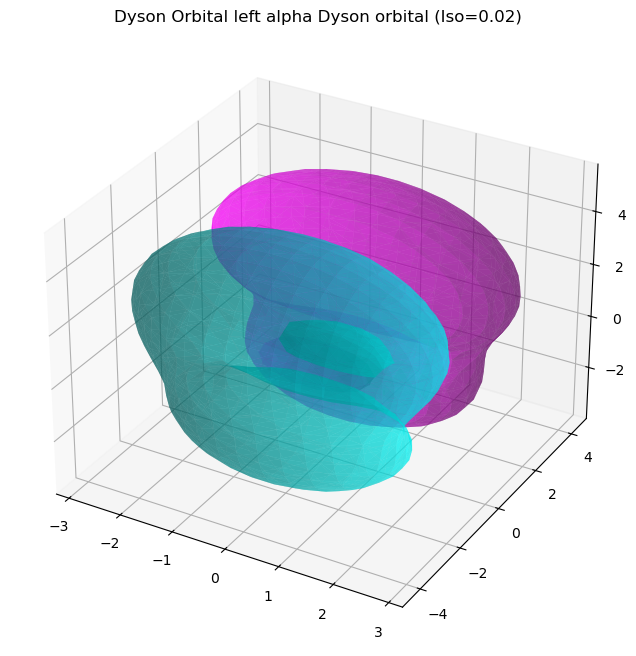

In [141]:
# === USER CONFIGURATION ===
FILENAME = "reference materials/CuO_pVTZ.out"
ORBITAL_INDEX = 0  # Select by index (0, 1, 2... from the list below)
GRID_EXT = 10.0     # Bohr extent (+/-)
POINTS = 50
ISO_LEVEL = 0.02
# ==========================

# 1. Load Data
data = load_qchem_output(FILENAME)
print(f"Loaded {len(data.atoms)} atoms and {len(data.dyson_orbitals)} Dyson orbitals.")
print(f"Basis functions: {data.n_basis_functions}")

print("\nAvailable Orbitals:")
for i, do in enumerate(data.dyson_orbitals):
    print(f"{i}: {do.label} (Trans: {do.transition}) Norm L={do.left_norm} R={do.right_norm}")

# 2. Build
builder = DysonOrbitalBuilder(data)
x_axis = np.linspace(-GRID_EXT, GRID_EXT, POINTS)
grid = UniformGrid(x_axis, x_axis, x_axis, unit="bohr")

print(f"\nBuilding orbital {ORBITAL_INDEX}...")
result = builder.build_orbital(ORBITAL_INDEX, grid, recenter=True)

# 3. Visualize
print(f"Orbital Centroid: {result.centroid_bohr}")
print(f"Calculated Spatial Norm: {np.sum(result.psi**2) * grid.differential_volume():.5f} (Should be 1.0)")

vals = result.psi
if HAS_SKIMAGE:
    try:
        spacing = grid.spacing()
        verts, faces, _, _ = marching_cubes(vals, level=ISO_LEVEL, spacing=spacing)
        verts_neg, faces_neg, _, _ = marching_cubes(vals, level=-ISO_LEVEL, spacing=spacing)
        
        # Shift verts to match grid coordinates
        origin = np.array([grid.x[0], grid.y[0], grid.z[0]])
        verts += origin
        verts_neg += origin
        
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_trisurf(verts[:,0], verts[:,1], verts[:,2], triangles=faces, color='cyan', alpha=0.5)
        ax.plot_trisurf(verts_neg[:,0], verts_neg[:,1], verts_neg[:,2], triangles=faces_neg, color='magenta', alpha=0.5)
        
        # Plot atoms (shifted relative to centroid if recentered)
        # NOTE: DysonOrbitalBuilder uses centered coordinates internally for evaluation
        # Use the atom centers from the data, but we need to shift them by the total shift applied.
        # The result object doesn't expose the final atom positions, so we just plot the cloud centered at 0 if recentered.
        # For accurate atom plotting, we would need to track the cumulative shift.
        # For now, just plot (0,0,0) as the orbital center.
        ax.scatter([0], [0], [0], c='k', marker='x', label='Orbital Centroid')
        
        ax.set_title(f"Dyson Orbital {result.label} (Iso={ISO_LEVEL})")
        plt.show()
    except Exception as e:
        print(f"Isosurface error: {e}")
        plt.imshow(vals[:,:,POINTS//2])
        plt.show()
else:
    plt.imshow(vals[:,:,POINTS//2])
    plt.show()